In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


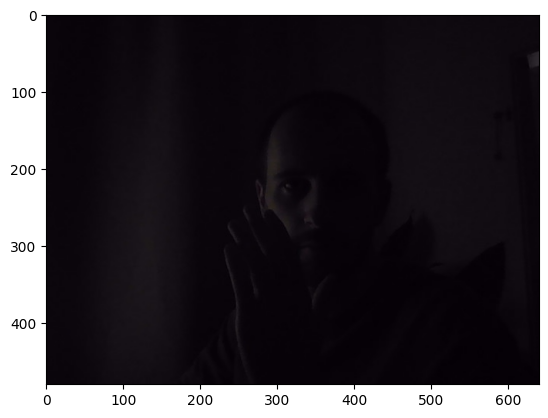

In [2]:
# Capture Frame
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

plt.imshow(frame)
plt.show()

In [44]:
frame2 = cv2.imread('../assets/man-standing.jpg')

In [3]:
def apply_erosion_filter(point_cloud, radius=10, min_neighbors=10):
    # Compute the neighborhood for each point
    kdtree = o3d.geometry.KDTreeFlann(point_cloud)
    points_to_keep = []

    for i in range(len(point_cloud.points)):
        # Find neighbors within the given radius
        [_, idx, _] = kdtree.search_radius_vector_3d(point_cloud.points[i], radius)
        
        # Keep the point if the number of neighbors is above the threshold
        if len(idx) > min_neighbors:
            points_to_keep.append(i)
    
    # Filter the point cloud
    filtered_points = np.asarray(point_cloud.points)[points_to_keep]

    # Create a new point cloud with the filtered points
    filtered_point_cloud = o3d.geometry.PointCloud()
    filtered_point_cloud.points = o3d.utility.Vector3dVector(filtered_points)

    return filtered_point_cloud

INFO:dinov2:using MLP layer as FFN


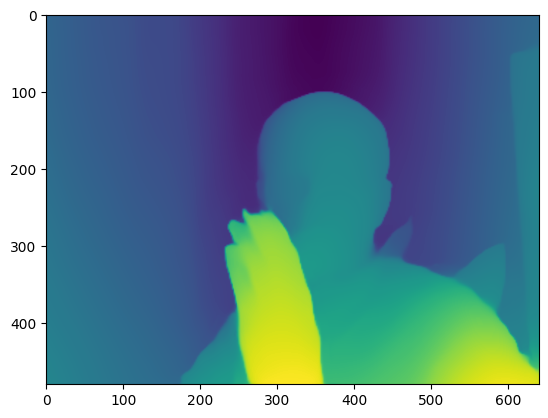

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [5]:
import sys
sys.path.append('../pipeline')

from pipeline.components.pc_generator.DepthEstimator import DepthEstimator
from pipeline.components.pc_generator.PointCloudGenerator import PointCloudGenerator

# Pipeline Starter
depth_estimator = DepthEstimator(visualize=False)
pointcloud_generator = PointCloudGenerator(visualize=False)

depth_image = depth_estimator.run_step(frame)
plt.imshow(depth_image)
plt.show()

pcd = pointcloud_generator.run_step(frame, depth_image)

o3d.visualization.draw_geometries([pcd], width=800, height=600)

pcd_filtered = apply_erosion_filter(pcd)
o3d.visualization.draw_geometries([pcd_filtered], width=800, height=600)

C:\dev\TU\ODS\ods-playground\vendor\Depth-Anything-V2
torch.Size([256, 256])
tensor([[9.1502e-10, 1.1910e-09, 3.3071e-09,  ..., 1.5228e-08, 4.3938e-08,
         1.6434e-07],
        [5.3893e-10, 6.6110e-10, 2.9165e-09,  ..., 2.6955e-08, 4.9634e-08,
         1.3678e-07],
        [6.2908e-10, 1.1504e-09, 7.6736e-09,  ..., 7.1110e-08, 8.1565e-08,
         1.4247e-07],
        ...,
        [9.3255e-08, 4.7128e-08, 4.5477e-08,  ..., 7.6626e-08, 2.8489e-08,
         1.6026e-08],
        [1.0198e-07, 3.8676e-08, 2.6965e-08,  ..., 5.1080e-08, 2.1139e-08,
         1.2853e-08],
        [1.6163e-07, 5.7650e-08, 3.0347e-08,  ..., 4.7387e-08, 2.1505e-08,
         1.2726e-08]])


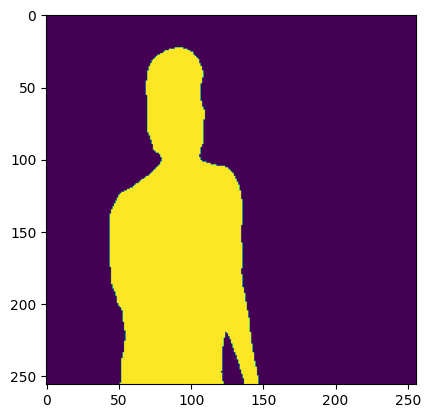

In [60]:
# TRYING WITH RMBG
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from PIL import Image

rmbg_model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
rmbg_model.to('cuda')
rmbg_model.eval()

image_size = (256, 256)
transform_image = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


#depth_pillow = Image.fromarray(depth_image).convert('RGB')
input_image = Image.open('../assets/man-standing.jpg')
input_images = transform_image(input_image).unsqueeze(0).to('cuda')
with torch.no_grad():
    preds = rmbg_model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
print(pred.shape)
print(pred)

mask = pred > 0.2
plt.imshow(mask)

In [ ]:
#
# Test with SAM
#

In [ ]:
frame3 = cv2.imread('../assets/man-standing.jpg')
